# Reconstruction in ROOT

In [1]:
import os
import sys
import ROOT
import time
import joblib
import subprocess
import numpy as np
from reconstruct import reconstruct

sys.path.append("..")
from helpers import filename_for

Welcome to JupyROOT 6.16/00


In [ ]:
start = time.time()
reconstruct(15, 30, 600, 500, 4, "inclxx", 0)
stop = time.time()
print(stop - start)

with open(filename_for(15, 30, 600, 500, 4, "inclxx", 0, "recotest.log")) as f:
    print(f.read())

In [ ]:
%%javascript
var s = document.createElement('script');
s.src='https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js';
document.body.appendChild(s);

In [ ]:
%jsroot on
file = filename_for(15, 30, 600, 500, 4, "inclxx", 0, "recotest.root")
tfile = ROOT.TFile.Open(os.fspath(file))

c1 = ROOT.TCanvas("c1", "c1", 800, 600)

h1 = tfile.Get("NeulandNeutronReconstructionMonCheat/fhErel4").Clone()
print(h1.GetEntries())
h1.Rebin(10)
h1.SetLineColor(1)

h2 = tfile.Get("NeulandNeutronReconstructionMonScikit/fhErel4").Clone()
print(h2.GetEntries())
h2.Rebin(10)
h2.SetLineColor(2)

h3 = tfile.Get("NeulandNeutronReconstructionMonRValue/fhErel4").Clone()
print(h3.GetEntries())
h3.Rebin(10)
h3.SetLineColor(3)

h5 = tfile.Get("NeulandNeutronReconstructionAutoSklearn/fhErel4").Clone()
print(h5.GetEntries())
h5.Rebin(10)
h5.SetLineColor(5)

h4 = tfile.Get("NeulandNeutronReconstructionMonKeras/fhErel4").Clone()
print(h4.GetEntries())
h4.Rebin(10)
h4.SetLineColor(4)

h1.Draw("")
h2.Draw("same")
h3.Draw("same")
h5.Draw("same")
h4.Draw("same")

c1.Draw()

In [ ]:
joblib.Parallel(n_jobs=-1)(joblib.delayed(reconstruct)(15, 30, 600, 500, 4, "inclxx", subrun) for subrun in range(20))
print("Done")

In [5]:
d = ["hadd", "-f", "-T", "results/reco3.root"] + [
    filename_for(15, 30, 600, 500, 4, "inclxx", subrun, "recotest3.root") for subrun in range(20)
]
subprocess.run(d)

CompletedProcess(args=['hadd', '-f', '-T', 'results/reco3.root', PosixPath('/srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/clusterfeature/../data/15m_30dp_600AMeV_500keV_4n.inclxx.00.recotest3.root'), PosixPath('/srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/clusterfeature/../data/15m_30dp_600AMeV_500keV_4n.inclxx.01.recotest3.root'), PosixPath('/srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/clusterfeature/../data/15m_30dp_600AMeV_500keV_4n.inclxx.02.recotest3.root'), PosixPath('/srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/clusterfeature/../data/15m_30dp_600AMeV_500keV_4n.inclxx.03.recotest3.root'), PosixPath('/srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/clusterfeature/../data/15m_30dp_600AMeV_500keV_4n.inclxx.04.recotest3.root'), PosixPath('/srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/clusterfeature/../data/15m_30dp_600AMeV_500keV_4n.inclxx.05.recotest3.r

hadd Target file: results/reco3.root
hadd compression setting for all ouput: 1
hadd Source file 1: /srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/clusterfeature/../data/15m_30dp_600AMeV_500keV_4n.inclxx.00.recotest3.root
hadd Source file 2: /srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/clusterfeature/../data/15m_30dp_600AMeV_500keV_4n.inclxx.01.recotest3.root
hadd Source file 3: /srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/clusterfeature/../data/15m_30dp_600AMeV_500keV_4n.inclxx.02.recotest3.root
hadd Source file 4: /srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/clusterfeature/../data/15m_30dp_600AMeV_500keV_4n.inclxx.03.recotest3.root
hadd Source file 5: /srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/clusterfeature/../data/15m_30dp_600AMeV_500keV_4n.inclxx.04.recotest3.root
hadd Source file 6: /srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/clusterfeature/../

Warning in <TList::Merge>: list is empty - nothing to merge
Warning in <TList::Merge>: list is empty - nothing to merge
Warning in <TList::Merge>: list is empty - nothing to merge
Warning in <TList::Merge>: list is empty - nothing to merge
Warning in <TList::Merge>: list is empty - nothing to merge
Warning in <TList::Merge>: list is empty - nothing to merge
Warning in <TList::Merge>: list is empty - nothing to merge
Warning in <TList::Merge>: list is empty - nothing to merge
Warning in <TList::Merge>: list is empty - nothing to merge
Warning in <TList::Merge>: list is empty - nothing to merge
Warning in <TList::Merge>: list is empty - nothing to merge
Warning in <TList::Merge>: list is empty - nothing to merge
Warning in <TList::Merge>: list is empty - nothing to merge
Warning in <TList::Merge>: list is empty - nothing to merge
Warning in <TList::Merge>: list is empty - nothing to merge
Warning in <TList::Merge>: list is empty - nothing to merge
Warning in <TList::Merge>: list is empty

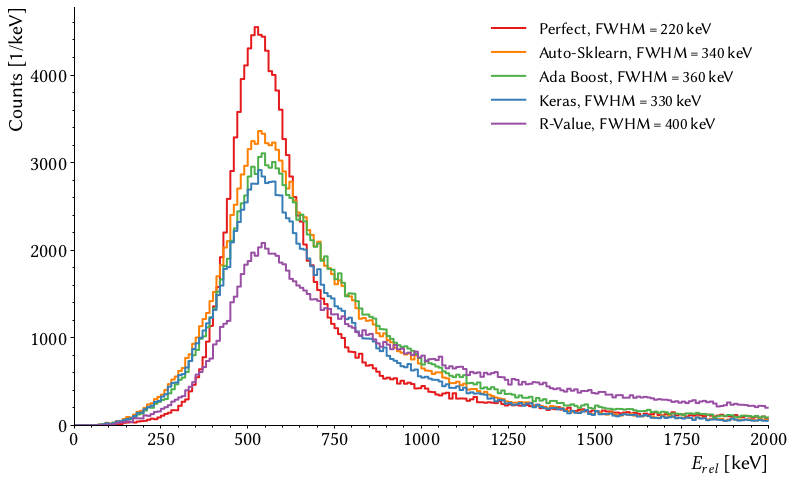

In [4]:
from plotconf import *
import rootpy.io
import rootpy.plotting.root2matplotlib as rplt

colors = palettable.colorbrewer.qualitative.Set1_9.mpl_colors


def get_and_fit(file, ax, name, label, color):
    h = file.Get(f"NeulandNeutronReconstructionMon{name}/fhErel4").Clone()
    h.Rebin(10)

    # xmin = 450
    # xmax = 750
    # fitresult = h.Fit("gaus", "S", "", xmin, xmax)
    # fun = fitresult.FittedFunction().GetFunction()
    # xs = np.arange(xmin, xmax, 1)
    # ys = [fun.Eval(x) for x in xs]
    # sigma = round(fitresult.GetParams()[2])
    # ax.plot(xs, ys, color="red")

    halfmax = h.GetMaximum() / 2

    y = 0
    xl = 20
    while y < halfmax:
        xl += 1
        y = h.GetBinContent(xl)
    #print(xl,y)
    
    y = 2 * halfmax 
    xr = 50
    while y > halfmax:
        xr +=1
        y = h.GetBinContent(xr)
    #print(xr, y)
    
    fwhm = (xr - xl) * 10
       
    rplt.step(h, axes=ax, label=f"{label}, FWHM\,=\,{fwhm}\,keV", color=color, linewidth=2)


file = rootpy.io.root_open("results/reco.root", "read")
file2 = rootpy.io.root_open("results/reco2.root", "read")

fig = plt.figure(figsize=(2 * 6.224, 2 * 6.224 / 1.618))
ax = fig.add_subplot(111)

get_and_fit(file, ax, "Cheat", "Perfect", colors[0])
get_and_fit(file, ax, "AutoSklearn", "Auto-Sklearn", colors[4])
get_and_fit(file2, ax, "AdaBoost", "Ada Boost", colors[2])
get_and_fit(file, ax, "Keras", "Keras", colors[1])
get_and_fit(file, ax, "RValue", "R-Value", colors[3])

ax.set_xlim(0, 2000)
ax.set_ylim(0, None)
ax.set_xlabel(r"$E_{rel}$ [keV]", horizontalalignment="right", x=1)
ax.set_ylabel(r"Counts [1/keV]", horizontalalignment="right", y=1)

ax.legend(loc="upper right", prop={"size": "small"})
# fig.savefig(f"results/erel-{neutron}n-{erel}.pdf", bbox_inches="tight")
display(fig)